# Index Compare Regime

The idea is that we'll compare the relative indices by using the z-score regime method

# Packages

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read Data

In [4]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(os.path.join(parent_path, "data"))

prices_path = os.path.join(data_path, "dm_prices.parquet")
rtns_path = os.path.join(data_path, "rtns.parquet")

df_prices_raw = pd.read_parquet(path = prices_path, engine = "pyarrow")
df_rtns_raw = pd.read_parquet(path = rtns_path, engine = "pyarrow")

# Split Returns by Regime

In [38]:
(df_prices_raw.query(
    "variable_0 == 'Adj Close'").
    dropna().
    drop(columns = ["value", "variable_0"]).
    rename(columns = {"variable_1": "ticker"}).
    groupby("ticker").
    agg(["count", "min", "max"])
    ["Date"])

,count,min,max
ticker,,,
EQAL,2211,2014-12-24,2023-10-06
EQWS,3079,2006-12-01,2019-02-27
IWB,5883,2000-05-19,2023-10-06
IWM,5878,2000-05-26,2023-10-06
IWV,5878,2000-05-26,2023-10-06
QQQ,6186,1999-03-10,2023-10-06
RSP,5145,2003-05-01,2023-10-06
SPY,7728,1993-01-29,2023-10-06


In [17]:
df_rtns = (df_rtns_raw.assign(
    z_score = lambda x: np.sign(x.z_score.shift(1))).
    dropna()
    [["z_score"]].
    reset_index())

In [76]:
stats = ["mean", "std", "skew"]

df_stats = (df_prices_raw.query(
    "variable_0 == 'Adj Close'").
    drop(columns = ["variable_0"]).
    rename(columns = {"variable_1": "ticker"}).
    pivot(index = "Date", columns = "ticker", values = "value").
    pct_change().
    reset_index().
    melt(id_vars = "Date").
    assign(value = lambda x: x.value * 100).
    merge(right = df_rtns, how = "inner", on = ["Date"]).
    groupby(["ticker", "z_score"]).
    agg(stats)
    ["value"].
    reset_index().
    pivot(index = "z_score", columns = "ticker", values = stats))

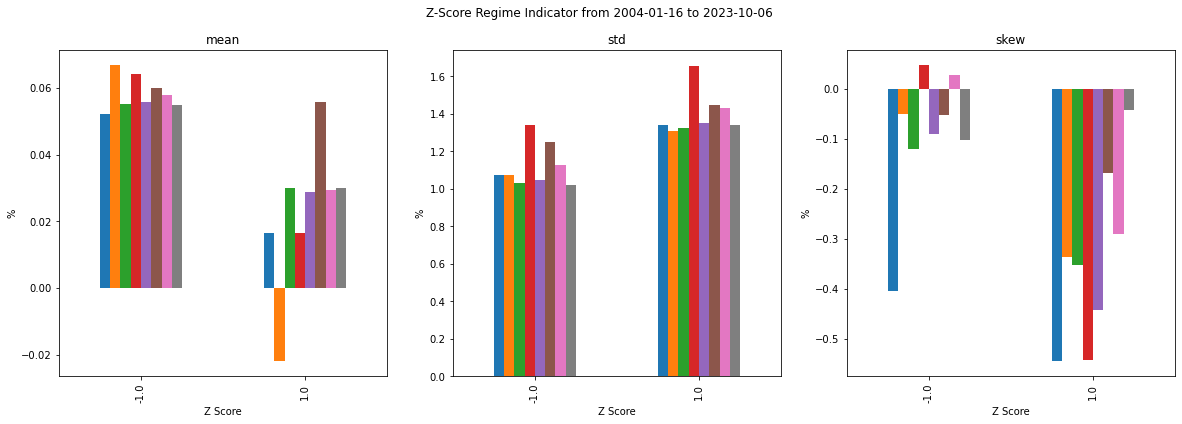

In [77]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))
for i, stat in enumerate(stats):
    
    (df_stats[
        stat].
        plot(
            ax = axes[i],
            kind = "bar",
            title = stat,
            legend = False,
            xlabel = "Z Score",
            ylabel = "%"))
    
fig.suptitle("Z-Score Regime Indicator from {} to {}".format(df_rtns.Date.min().date(), df_rtns.Date.max().date()))
plt.show()